# Author-Topic LDA

In this notebook, I use the corpus, dictionary and other data built in [text_mining_and_processing.ipynb](text_mining_and_processing.ipynb) to train a Author-Topic LDA model.

Latent Dirichlet Allocation ([LDA](https://en.wikipedia.org/wiki/Dirichlet_distribution); [Blei, Ng, & Jordan, 2003](http://www.jmlr.org/papers/v3/blei03a.html)) is a topic modelling technique.
In a text corpus, each document is associated with a multinomial distribution over topics, and each topic is associated with a multinomial distribution over words. Moreover, Dirichlet distributions are used as prior distributions.

The author-topic model extends LDA to include authorship information. 
For the author-topic model, each author is associated with a multonimial distribution over topics (instead of each documents). In addition, the model can also handle documents with more than one author.

The models can be represented graphically (taken from [Rosen-Zvi, Griffiths, Steyvers, & Smyth, 2012](https://arxiv.org/abs/1207.4169)):


I use the algorithms provided by the [gensim](https://radimrehurek.com/gensim/) Python library, which are based on [Hoffman, Bach, & Blei, 2010](http://papers.nips.cc/paper/3902-online-learning-for-latentdirichlet-allocation!) for LDA and [Rosen-Zvi, Griffiths, Steyvers, & Smyth, 2012](https://arxiv.org/abs/1207.4169) for the author-topic extension. 

-------------------------

In [177]:
from tqdm import tqdm_notebook as tqdm
import json
from collections import OrderedDict
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from gensim import models, corpora
import pyLDAvis
import pyLDAvis.gensim

In [178]:
# loading the data

dictionary = corpora.Dictionary.load('data/dictionary')
corpus = list(corpora.MmCorpus('data/corpus.mm'))
with open('data/author2doc.json') as f: 
    author2doc = json.load(f)
with open('data/tokenized_data.json') as f: 
    tokenized_data = json.load(f)
    
# Use the following instead for data including proper nouns:
    
# dictionary = corpora.Dictionary.load('data/dictionary_propn')
# corpus = list(corpora.MmCorpus('data/corpus_propn.mm'))
# with open('data/author2doc_propn.json') as f: 
#     author2doc = json.load(f)
# with open('data/tokenized_data_propn.json') as f: 
#     tokenized_data = json.load(f)

## Topic coherence

The number of topics needs to be set for LDA, and it is often a highly non-trivial task.

My approach here is to train LDA models with different values of number of topics, and choose the one with the highest coherence value.
Sometimes, choosing a value that marks the end of a rapid growth of topic coherence is a better method to obtain meaningfull and interpretable topics.
Typically, if the same words is repeated in multiple topics, it is a sign that the number of topics is too large.

There are other approaches to evaluate the topic models such as perplexity. However, topic coherence is usually better correlated to human judgment than perplexity.

In [210]:
def compute_coherence_values(dictionary, corpus, texts, author2doc, n_min, n_max, step=1, return_models=False):
    """
    Compute c_v coherence for different numbers of topics

    Args:
    ----
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts (list of list of str): List of input tokenized texts.
    n_min (int): min number of topics.
    n_max (int): max number of topics.

    Returns:
    -------
    trained_models (OrderedDict): Dictionary of LDA topic models corresponding to a number of topics.
    coherence_values (OrderedDict): Dictionary of Coherence values corresponding to a number of topics.
    """
    trained_models = OrderedDict()
    coherence_values = OrderedDict()
    
    for n_topics in tqdm(range(n_min, n_max, step)):
        trained_models[n_topics] = models.AuthorTopicModel(corpus,
                                                           num_topics=n_topics,
                                                           id2word=dictionary,
                                                           author2doc=author2doc, 
                                                           passes=50,
                                                           alpha='auto',
                                                           eta='symmetric',
                                                           gamma_threshold=1e-5,
                                                           random_state=10)
        
    cm = models.CoherenceModel.for_models(trained_models.values(),
                                          dictionary=dictionary,
                                          texts=texts,
                                          coherence='c_v')
    
    coherence_estimates = cm.compare_models(trained_models.values())
    coherence_values = OrderedDict(zip(trained_models.keys(), [c for _, c in coherence_estimates]))
    if return_models:
        return coherence_values, trained_models
    else:
        return coherence_values

In [211]:
def plot_coherence(coherences_dict, ax=None):
    """
    Plot coherence values as a function of the number of topics
    
    Args:
    ----
    coherences_dict (dict of int: float): dictionary of coherence values with num_topics as keys.
    ax (matplotlib Axes object)
    """
    if ax is None:
        ax = plt.gca()
    ntopics_vs_coherence = list(coherences_dict.items())
    ntopics_vs_coherence.sort()
    best_n, max_coherence = max(ntopics_vs_coherence, key=lambda x: x[1])
    ax.plot(*zip(*ntopics_vs_coherence))
    c = ax._get_lines.get_next_color()
    ax.axvline(best_n, linestyle='--', color=c, label='maximum coherence')
    ax.set_xticks([n for n, _ in ntopics_vs_coherence])
    ax.set_xlabel('number of topics')
    ax.set_ylabel('coherence')
    ax.legend()

In [212]:
coherence_values = compute_coherence_values(dictionary, corpus, tokenized_data, author2doc,
                                            n_min=2, n_max=15)

A Jupyter Widget

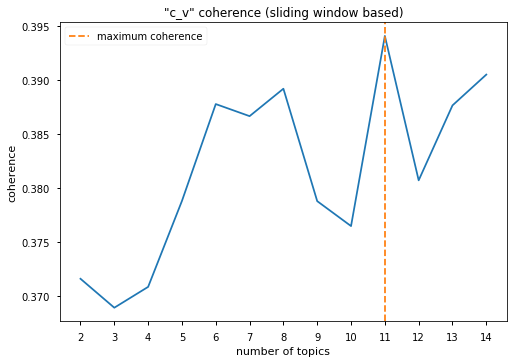

In [213]:
plt.style.use('seaborn-notebook')
plot_coherence(coherence_values)
plt.title('"c_v" coherence (sliding window based)');

It looks like 8 topics is a good choice. Note that the shape of the curve depends quite a lot on the random seed. There is some luck involved.
After trying out several numbers and random seeds, I found that a higher number of topics is good to detect more unusual and sparsely represented topics. But then, many of the main topics overlap.

## Training and results

Finally, I train the model using 8 topics.

As discussed in [Wallach, Mimno, & McCallum, 2009](http://papers.nips.cc/paper/3854-rethinking-lda-why-priors-matter), it is generally a good a idea to choose an asymmetric Dirichlet prior over the document-topic distributions (or author-topic), and a symetric one over the topic-word distributions. Those correspond to `alpha` and `eta` in the gensim implementation of LDA, respectively. Additionally, I use `alpha='auto'`, so that the asymmetric prior is learnt directly from the data.

I also use a low value for `gamma_threshold`, which is the threshold value of $\gamma$ (the topic difference between consecutive two topics, i.e. variations between subsequent inferences) until which the iterations continue.

In [214]:
num_topics = 8

lda_atmodel = models.AuthorTopicModel(
    corpus,
    num_topics=num_topics,
    id2word=dictionary,     # dict of int: str (word id -> word)
    author2doc=author2doc,  # dict of str: int (author -> document id)
    passes=50,              # number of passes through the corpus during training
    alpha='auto',           # parameter of the Dirichlet prior on the per-document topic distributions
    eta='symmetric',        # parameter of the Dirichlet prior on the per-topic word distributions 
    random_state=10,
    gamma_threshold=1e-5    # Convergence criterion of the `online variational Bayes for LDA` algorithm
)

print("The α's obtained from `alpha='auto'` are:")
print(lda_atmodel.alpha)

The α's obtained from `alpha='auto'` are:
[0.04869923 0.0467623  0.0360983  0.17585151 0.11177983 0.12520942
 0.05918639 0.03670379]


## Topic keywords

The next step is to examine the obtained topics and the associated _keywords_.
The most relevant keywords of each topics are printed below.

I also included the nice interactive chart of the pyLDAvis, a Python library for interactive topic model visualization.

Although some topics are closely related, there is some variations amongs the topics.
As expected of SF novels, some themes are dominant (e.g. space travel). As a result, several topics share the same overall theme, and it is difficult to tell them apart. (Nevertheless, the overall theme is interpretable).

It is however remarkable that the algorithm could detect some topics only sparsely represented in the corpus. This would not have been possible without an asymmetric `alpha` (e.g. topic 3 below, about family)
There is also major topics (e.g. topic 4 below), which countain many important keywords. Those are themes appearing very often in the SF litterature (e.g. planets, power & control).

In [215]:
print("Author-Topic LDA Model:")
# Print the Keyword in all topics
for (index, keywords) in lda_atmodel.print_topics(-1, 8):
    print(f'Topic #{index + 1}:')
    print('\t', keywords)
# pprint(lda_atmodel.print_topics(-1, 10))

Author-Topic LDA Model:
Topic #1:
	 0.010*"find" + 0.006*"return" + 0.006*"ship" + 0.006*"crew" + 0.006*"island" + 0.005*"take" + 0.005*"man" + 0.005*"time"
Topic #2:
	 0.008*"man" + 0.007*"life" + 0.007*"world" + 0.006*"time" + 0.005*"find" + 0.005*"society" + 0.005*"war" + 0.005*"take"
Topic #3:
	 0.012*"find" + 0.010*"father" + 0.009*"tell" + 0.008*"child" + 0.008*"leave" + 0.007*"life" + 0.007*"people" + 0.007*"man"
Topic #4:
	 0.008*"find" + 0.007*"planet" + 0.007*"kill" + 0.007*"time" + 0.006*"world" + 0.006*"force" + 0.006*"take" + 0.005*"ship"
Topic #5:
	 0.013*"find" + 0.010*"kill" + 0.007*"leave" + 0.007*"take" + 0.007*"tell" + 0.007*"time" + 0.007*"escape" + 0.006*"ship"
Topic #6:
	 0.007*"human" + 0.007*"time" + 0.005*"world" + 0.005*"planet" + 0.004*"find" + 0.004*"people" + 0.004*"work" + 0.004*"life"
Topic #7:
	 0.008*"time" + 0.007*"world" + 0.006*"life" + 0.005*"science" + 0.005*"work" + 0.005*"travel" + 0.005*"planet" + 0.005*"ship"
Topic #8:
	 0.029*"ship" + 0.015*"p

## Topic visualization

Simply using the top keywords (with the highest weights) is not always the best method to interpret topics.
With the interactive chart of pyLDAvis, we can adjust the relevance metric $\lambda$, which is used to calculate the _relevance_ of the words (see [Sievert & Shirley (2014)](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)).
I found that $\lambda \approx 0.6$ gives interesting results and helps interepret the topics.

Note: I had to modify the pyLDAvis/gensim.py file in order to use the library with the author-topic model:

I replaced line 48

`gamma, _ = topic_model.inference(corpus)`

with

`doc2author = gensim.models.atmodel.construct_doc2author(topic_model.corpus, topic_model.author2doc)`<p>
`gamma, _ = topic_model.inference(topic_model.corpus, topic_model.author2doc, doc2author, 0)`

In [216]:
lda_display = pyLDAvis.gensim.prepare(lda_atmodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Topic interpretation

This is the interpretation I came up with for each topic:

- Topic #1: Sea expedition
- Topic #2: World, society & war 
- Topic #3: Family
- Topic #4: Planets, force & power 
- Topic #5: Fight & action (find, kill & escape)
- Topic #6: Humans, planets & space colonization
- Topic #7: Time travel
- Topic #8: Space ships and space travel

Finally, I plot the topic distribution for several authors.

In [222]:
def plot_topic_distribution(author, num_topics, ax=None):
    if ax is None:
        ax = plt.gca()
        
    x = list(range(1, num_topics+1))
    height = np.zeros(num_topics)
    author_topics = lda_atmodel.get_author_topics(author)
    for i, h in author_topics:
        height[i] = h
    ax.bar(x=x, height=height, tick_label=x)
    n_novels = len(author2doc[author])
    n_tokens = sum(len(tokenized_data[i]) for i in author2doc[author])
    ax.set_title(f'{author} ({n_novels} novels, {n_tokens} tokens)')
    ax.set_ylim([0, 1])
    
def plot_topic_distribution_by_author(authors, num_topics, ax=None):
    n_authors = len(authors)
    n_col = 3
    n_row = (n_authors - 1) // n_col + 1
    size = 4.5
    fig, axes = plt.subplots(n_row, n_col, figsize=(size*n_col, size*0.8*n_row))
    axes = axes.flat
    for ax, author in zip(axes, subset_of_authors):
        plot_topic_distribution(author, num_topics, ax=ax)
    fig.suptitle('Topic distribution by author', y=1.1, fontsize=20)
    plt.tight_layout()

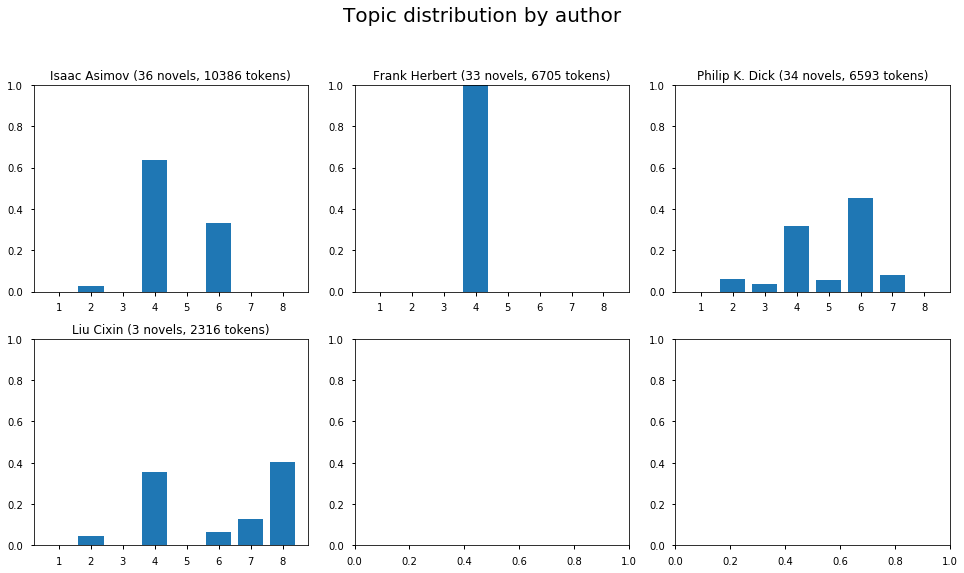

In [223]:
subset_of_authors = ['Isaac Asimov', 'Frank Herbert', 'Philip K. Dick', 'Liu Cixin']
plot_topic_distribution_by_author(subset_of_authors, num_topics)

Topic 4 appears for all 4 authors, which makes sense. Looking at Isaac Asimov, topics 4 & 6 are about planets, power, and colonization. That seems about right! Frank Hebert's Dune is all about force and power in a interplanetary setup, so topic 4 is very fitting.